# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    kdd_test__2labels = pd.read_pickle("dataset/kdd_test__2labels.pkl")

    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Normal','is_Attack']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]
    
    x_test__input = dataset.kdd_test__2labels.drop(output_columns_2labels, axis = 1)
    y_test_ = dataset.kdd_test__2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)
    x_test_ = ss.transform(x_test__input)

    y_train = y_output.values
    y_test = y_test.values
    y_test_ = y_test_.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score', 'test_score_20', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_dense_only_nsl_kdd/hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                              preprocess.y_train, 
                                                                              test_size=0.1)
                    batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                               batch_iterations)

                    for i in batch_indices:

                        def train_batch():
                            nonlocal train_loss
                            _, train_loss = sess.run([net.train_op, 
                                                               net.regularized_loss, 
                                                               ], #net.summary_op
                                                              feed_dict={net.x: x_train[i,:], 
                                                                         net.y_: y_train[i,:], 
                                                                         net.keep_prob:0.5, net.lr:lr})

                        train_batch()
                        #summary_writer_train.add_summary(summary_str, epoch)
                        while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                            print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            net.saver.restore(sess, 
                                              tf.train.latest_checkpoint('dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}'
                                                                         .format(epochs,h,f)))
                            train_batch()


                    valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                          feed_dict={net.x: x_valid, 
                                                                     net.y_: y_valid, 
                                                                     net.keep_prob:1, net.lr:lr})
                    #summary_writer_valid.add_summary(summary_str, epoch)


                    accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test, 
                                                                             net.y_: preprocess.y_test, 
                                                                             net.keep_prob:1, net.lr:lr})
                    
                    accuracy_, pred_value_, actual_value_, y_pred_ = sess.run([net.tf_accuracy, 
                                                                   net.pred, 
                                                                   net.actual, net.y], 
                                                                  feed_dict={net.x: preprocess.x_test_, 
                                                                             net.y_: preprocess.y_test_, 
                                                                             net.keep_prob:1, net.lr:lr})

                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                    print("Accuracy on Test data: {}, {}".format(accuracy, accuracy_))

                    if accuracy > Train.best_acc_global:
                        Train.best_acc_global = accuracy
                        Train.pred_value = pred_value
                        Train.actual_value = actual_value
                        Train.pred_value = pred_value_
                        Train.actual_value = actual_value_
                        Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                    if accuracy > Train.best_acc:
                        Train.best_acc = accuracy

                        if not (np.isnan(train_loss)):
                            net.saver.save(sess, 
                                       "dataset/tf_dense_only_nsl_kdd/hidden_layers_{}_features_count_{}".format(h,f),
                                        global_step = epochs)
                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                        Train.predictions.update({"{}_{}_{}".format(epochs*len(lrs),f,h):(curr_pred, 
                                                   Train.result(epochs*len(lrs), f, h, valid_accuracy, accuracy, accuracy_, time.perf_counter() - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))


In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]
    
    epochs = [30]
    lrs = [1e-5, 1e-5/2, 1e-5/4]
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f, lrs)
        

Current Layer Attributes - epochs:30 hidden layers:2 features count:4
Step 1 | Training Loss: 0.688647 | Validation Accuracy: 0.754326
Accuracy on Test data: 0.5904896855354309, 0.43426159024238586
Step 2 | Training Loss: 0.663452 | Validation Accuracy: 0.815606
Accuracy on Test data: 0.6467352509498596, 0.5232067704200745
Step 3 | Training Loss: 0.639511 | Validation Accuracy: 0.834101
Accuracy on Test data: 0.6730393767356873, 0.5643881559371948
Step 4 | Training Loss: 0.608192 | Validation Accuracy: 0.852913
Accuracy on Test data: 0.6816447973251343, 0.5762025117874146
Step 5 | Training Loss: 0.581559 | Validation Accuracy: 0.865375
Accuracy on Test data: 0.6940205693244934, 0.5958649516105652
Step 6 | Training Loss: 0.573773 | Validation Accuracy: 0.901889
Accuracy on Test data: 0.7789655923843384, 0.60303795337677
Step 7 | Training Loss: 0.561666 | Validation Accuracy: 0.925861
Accuracy on Test data: 0.7867725491523743, 0.6137552857398987
Step 8 | Training Loss: 0.556861 | Validat

Step 5 | Training Loss: 0.442650 | Validation Accuracy: 0.969440
Accuracy on Test data: 0.7637952566146851, 0.5518143177032471
Step 6 | Training Loss: 0.438194 | Validation Accuracy: 0.969757
Accuracy on Test data: 0.7635734677314758, 0.5513923764228821
Step 7 | Training Loss: 0.434743 | Validation Accuracy: 0.968090
Accuracy on Test data: 0.7633516788482666, 0.5509704351425171
Step 8 | Training Loss: 0.447738 | Validation Accuracy: 0.971583
Accuracy on Test data: 0.7627306580543518, 0.5497890114784241
Step 9 | Training Loss: 0.423665 | Validation Accuracy: 0.970313
Accuracy on Test data: 0.7625975608825684, 0.549535870552063
Step 10 | Training Loss: 0.453151 | Validation Accuracy: 0.970948
Accuracy on Test data: 0.7623757719993591, 0.549113929271698
Step 11 | Training Loss: 0.433026 | Validation Accuracy: 0.968090
Accuracy on Test data: 0.7621983885765076, 0.548776388168335
Step 12 | Training Loss: 0.431541 | Validation Accuracy: 0.971662
Accuracy on Test data: 0.7619321942329407, 0.5

Step 9 | Training Loss: 0.392542 | Validation Accuracy: 0.970710
Accuracy on Test data: 0.7703158259391785, 0.5642194151878357
Step 10 | Training Loss: 0.391376 | Validation Accuracy: 0.972773
Accuracy on Test data: 0.7701383829116821, 0.5638818740844727
Step 11 | Training Loss: 0.386932 | Validation Accuracy: 0.971900
Accuracy on Test data: 0.7699165940284729, 0.5634599328041077
Step 12 | Training Loss: 0.409320 | Validation Accuracy: 0.967693
Accuracy on Test data: 0.7697835564613342, 0.5632067322731018
Step 13 | Training Loss: 0.389847 | Validation Accuracy: 0.969440
Accuracy on Test data: 0.7697391510009766, 0.5631223917007446
Step 14 | Training Loss: 0.383404 | Validation Accuracy: 0.967058
Accuracy on Test data: 0.7696061134338379, 0.5628691911697388
Step 15 | Training Loss: 0.396521 | Validation Accuracy: 0.969281
Accuracy on Test data: 0.7694286704063416, 0.5625316500663757
Step 16 | Training Loss: 0.399097 | Validation Accuracy: 0.969836
Accuracy on Test data: 0.76911818981170

Step 13 | Training Loss: 0.468416 | Validation Accuracy: 0.948246
Accuracy on Test data: 0.8404009938240051, 0.7027848362922668
Step 14 | Training Loss: 0.433003 | Validation Accuracy: 0.945626
Accuracy on Test data: 0.8368967175483704, 0.696033775806427
Step 15 | Training Loss: 0.454434 | Validation Accuracy: 0.950865
Accuracy on Test data: 0.8350337147712708, 0.6919831037521362
Step 16 | Training Loss: 0.429293 | Validation Accuracy: 0.953485
Accuracy on Test data: 0.8329932689666748, 0.6875949501991272
Step 17 | Training Loss: 0.444306 | Validation Accuracy: 0.957612
Accuracy on Test data: 0.82948899269104, 0.6803375482559204
Step 18 | Training Loss: 0.416659 | Validation Accuracy: 0.959756
Accuracy on Test data: 0.8261621594429016, 0.6735864877700806
Step 19 | Training Loss: 0.402559 | Validation Accuracy: 0.965233
Accuracy on Test data: 0.8240330219268799, 0.6687763929367065
Step 20 | Training Loss: 0.411491 | Validation Accuracy: 0.962216
Accuracy on Test data: 0.821726381778717,

Step 18 | Training Loss: 0.348772 | Validation Accuracy: 0.972377
Accuracy on Test data: 0.7841110825538635, 0.5904641151428223
Step 19 | Training Loss: 0.353500 | Validation Accuracy: 0.969598
Accuracy on Test data: 0.7841110825538635, 0.5904641151428223
Step 20 | Training Loss: 0.362402 | Validation Accuracy: 0.972932
Accuracy on Test data: 0.784022331237793, 0.5902953743934631
Step 21 | Training Loss: 0.355385 | Validation Accuracy: 0.970710
Accuracy on Test data: 0.7839779853820801, 0.5902109742164612
Step 22 | Training Loss: 0.341606 | Validation Accuracy: 0.970313
Accuracy on Test data: 0.7838892936706543, 0.5900421738624573
Step 23 | Training Loss: 0.340144 | Validation Accuracy: 0.970233
Accuracy on Test data: 0.7837561964988708, 0.5897890329360962
Step 24 | Training Loss: 0.347296 | Validation Accuracy: 0.970392
Accuracy on Test data: 0.7836675047874451, 0.5896202325820923
Step 25 | Training Loss: 0.351590 | Validation Accuracy: 0.971742
Accuracy on Test data: 0.78357875347137

Step 22 | Training Loss: 0.357888 | Validation Accuracy: 0.969678
Accuracy on Test data: 0.7845990061759949, 0.5913923978805542
Step 23 | Training Loss: 0.359079 | Validation Accuracy: 0.972377
Accuracy on Test data: 0.7843328714370728, 0.5908860564231873
Step 24 | Training Loss: 0.344798 | Validation Accuracy: 0.972138
Accuracy on Test data: 0.7842441201210022, 0.5907173156738281
Step 25 | Training Loss: 0.345807 | Validation Accuracy: 0.970630
Accuracy on Test data: 0.7838449478149414, 0.5899578332901001
Step 26 | Training Loss: 0.347475 | Validation Accuracy: 0.969757
Accuracy on Test data: 0.7836231589317322, 0.5895358920097351
Step 27 | Training Loss: 0.362809 | Validation Accuracy: 0.972615
Accuracy on Test data: 0.7838005423545837, 0.5898734331130981
Step 28 | Training Loss: 0.342319 | Validation Accuracy: 0.970551
Accuracy on Test data: 0.7838449478149414, 0.5899578332901001
Step 29 | Training Loss: 0.343624 | Validation Accuracy: 0.973170
Accuracy on Test data: 0.7837561964988

Step 26 | Training Loss: 0.656294 | Validation Accuracy: 0.533736
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 27 | Training Loss: 0.663010 | Validation Accuracy: 0.537149
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 28 | Training Loss: 0.657551 | Validation Accuracy: 0.535799
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 29 | Training Loss: 0.662715 | Validation Accuracy: 0.532545
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 30 | Training Loss: 0.647924 | Validation Accuracy: 0.538419
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 1 | Training Loss: 0.653061 | Validation Accuracy: 0.533259
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 2 | Training Loss: 0.653730 | Validation Accuracy: 0.536037
Accuracy on Test data: 0.43075764179229736, 0.18160337209701538
Step 3 | Training Loss: 0.654157 | Validation Accuracy: 0.529608
Accuracy on Test data: 0.43

Step 30 | Training Loss: 0.641796 | Validation Accuracy: 0.967614
Accuracy on Test data: 0.730438232421875, 0.4905485212802887
Current Layer Attributes - epochs:30 hidden layers:4 features count:8
Step 1 | Training Loss: 0.707786 | Validation Accuracy: 0.643832
Accuracy on Test data: 0.47192156314849854, 0.22388185560703278
Step 2 | Training Loss: 0.725274 | Validation Accuracy: 0.668360
Accuracy on Test data: 0.47995030879974365, 0.22413502633571625
Step 3 | Training Loss: 0.694763 | Validation Accuracy: 0.691618
Accuracy on Test data: 0.48828956484794617, 0.23054851591587067
Step 4 | Training Loss: 0.696800 | Validation Accuracy: 0.700826
Accuracy on Test data: 0.49551987648010254, 0.23755274713039398
Step 5 | Training Loss: 0.700990 | Validation Accuracy: 0.731624
Accuracy on Test data: 0.5131298899650574, 0.248776376247406
Step 6 | Training Loss: 0.666361 | Validation Accuracy: 0.768932
Accuracy on Test data: 0.6005589365959167, 0.26759493350982666
Step 7 | Training Loss: 0.706577 

Step 4 | Training Loss: 0.542115 | Validation Accuracy: 0.969598
Accuracy on Test data: 0.7583392262458801, 0.5415189862251282
Step 5 | Training Loss: 0.569013 | Validation Accuracy: 0.970392
Accuracy on Test data: 0.7581174373626709, 0.5410970449447632
Step 6 | Training Loss: 0.540213 | Validation Accuracy: 0.969281
Accuracy on Test data: 0.7578513026237488, 0.5405907034873962
Step 7 | Training Loss: 0.569044 | Validation Accuracy: 0.966820
Accuracy on Test data: 0.7577182650566101, 0.5403375625610352
Step 8 | Training Loss: 0.545232 | Validation Accuracy: 0.967931
Accuracy on Test data: 0.7574964761734009, 0.5399156212806702
Step 9 | Training Loss: 0.551269 | Validation Accuracy: 0.968487
Accuracy on Test data: 0.7574077248573303, 0.5396624207496643
Step 10 | Training Loss: 0.560047 | Validation Accuracy: 0.971583
Accuracy on Test data: 0.758073091506958, 0.5409282445907593
Step 11 | Training Loss: 0.538831 | Validation Accuracy: 0.970392
Accuracy on Test data: 0.7580287456512451, 0.

Step 8 | Training Loss: 0.493585 | Validation Accuracy: 0.957215
Accuracy on Test data: 0.7988378405570984, 0.6196624636650085
Step 9 | Training Loss: 0.501857 | Validation Accuracy: 0.955390
Accuracy on Test data: 0.7977732419967651, 0.6176371574401855
Step 10 | Training Loss: 0.499403 | Validation Accuracy: 0.956342
Accuracy on Test data: 0.7963981628417969, 0.6150211095809937
Step 11 | Training Loss: 0.494187 | Validation Accuracy: 0.959359
Accuracy on Test data: 0.7949343323707581, 0.6121519207954407
Step 12 | Training Loss: 0.476615 | Validation Accuracy: 0.954120
Accuracy on Test data: 0.7936923503875732, 0.6097046136856079
Step 13 | Training Loss: 0.490534 | Validation Accuracy: 0.956898
Accuracy on Test data: 0.7934262156486511, 0.6091983318328857
Step 14 | Training Loss: 0.468792 | Validation Accuracy: 0.958724
Accuracy on Test data: 0.7932487726211548, 0.6088607311248779
Step 15 | Training Loss: 0.465154 | Validation Accuracy: 0.959279
Accuracy on Test data: 0.792849540710449

Step 12 | Training Loss: 0.550209 | Validation Accuracy: 0.931656
Accuracy on Test data: 0.7953779101371765, 0.6150211095809937
Step 13 | Training Loss: 0.533130 | Validation Accuracy: 0.934831
Accuracy on Test data: 0.7947125434875488, 0.6135864853858948
Step 14 | Training Loss: 0.540187 | Validation Accuracy: 0.937530
Accuracy on Test data: 0.7906316518783569, 0.6058228015899658
Step 15 | Training Loss: 0.537929 | Validation Accuracy: 0.944436
Accuracy on Test data: 0.7817157506942749, 0.5889451503753662
Step 16 | Training Loss: 0.500174 | Validation Accuracy: 0.947611
Accuracy on Test data: 0.7812278270721436, 0.5886076092720032
Step 17 | Training Loss: 0.513452 | Validation Accuracy: 0.952294
Accuracy on Test data: 0.7817157506942749, 0.5889451503753662
Step 18 | Training Loss: 0.484864 | Validation Accuracy: 0.953247
Accuracy on Test data: 0.7817157506942749, 0.5886920094490051
Step 19 | Training Loss: 0.494519 | Validation Accuracy: 0.953008
Accuracy on Test data: 0.7847764492034

Step 17 | Training Loss: 0.359505 | Validation Accuracy: 0.968170
Accuracy on Test data: 0.7476490139961243, 0.5218565464019775
Step 18 | Training Loss: 0.355384 | Validation Accuracy: 0.968725
Accuracy on Test data: 0.7472941875457764, 0.5210970640182495
Step 19 | Training Loss: 0.355885 | Validation Accuracy: 0.970868
Accuracy on Test data: 0.7469836473464966, 0.5205063223838806
Step 20 | Training Loss: 0.359197 | Validation Accuracy: 0.965947
Accuracy on Test data: 0.746806263923645, 0.5200843811035156
Step 21 | Training Loss: 0.368413 | Validation Accuracy: 0.969757
Accuracy on Test data: 0.7467175126075745, 0.5199156403541565
Step 22 | Training Loss: 0.359133 | Validation Accuracy: 0.967296
Accuracy on Test data: 0.7466288208961487, 0.5197468400001526
Step 23 | Training Loss: 0.364718 | Validation Accuracy: 0.970075
Accuracy on Test data: 0.7464513778686523, 0.5194092988967896
Step 24 | Training Loss: 0.365552 | Validation Accuracy: 0.967217
Accuracy on Test data: 0.74640703201293

Step 21 | Training Loss: 0.622407 | Validation Accuracy: 0.943404
Accuracy on Test data: 0.7875709533691406, 0.6037974953651428
Step 22 | Training Loss: 0.628917 | Validation Accuracy: 0.947214
Accuracy on Test data: 0.7872604727745056, 0.6032067537307739
Step 23 | Training Loss: 0.644757 | Validation Accuracy: 0.945468
Accuracy on Test data: 0.7869499921798706, 0.6025316715240479
Step 24 | Training Loss: 0.631799 | Validation Accuracy: 0.946023
Accuracy on Test data: 0.7864176630973816, 0.6011814475059509
Step 25 | Training Loss: 0.627090 | Validation Accuracy: 0.944753
Accuracy on Test data: 0.7859740853309631, 0.600337564945221
Step 26 | Training Loss: 0.628898 | Validation Accuracy: 0.947373
Accuracy on Test data: 0.7857522964477539, 0.599746823310852
Step 27 | Training Loss: 0.633327 | Validation Accuracy: 0.947531
Accuracy on Test data: 0.7851312756538391, 0.5984809994697571
Step 28 | Training Loss: 0.638883 | Validation Accuracy: 0.948563
Accuracy on Test data: 0.784687697887420

Step 25 | Training Loss: 0.625929 | Validation Accuracy: 0.945626
Accuracy on Test data: 0.8679027557373047, 0.75274258852005
Step 26 | Training Loss: 0.632121 | Validation Accuracy: 0.946420
Accuracy on Test data: 0.8682576417922974, 0.7534177303314209
Step 27 | Training Loss: 0.618264 | Validation Accuracy: 0.945468
Accuracy on Test data: 0.8671043515205383, 0.751223623752594
Step 28 | Training Loss: 0.607263 | Validation Accuracy: 0.951183
Accuracy on Test data: 0.8666607737541199, 0.750379741191864
Step 29 | Training Loss: 0.608512 | Validation Accuracy: 0.949278
Accuracy on Test data: 0.866084098815918, 0.749113917350769
Step 30 | Training Loss: 0.608499 | Validation Accuracy: 0.951818
Accuracy on Test data: 0.8658623099327087, 0.748691976070404
Step 1 | Training Loss: 0.615672 | Validation Accuracy: 0.953247
Accuracy on Test data: 0.8658179640769958, 0.748691976070404
Step 2 | Training Loss: 0.612836 | Validation Accuracy: 0.952770
Accuracy on Test data: 0.8654630780220032, 0.748

Step 30 | Training Loss: 0.580925 | Validation Accuracy: 0.963328
Accuracy on Test data: 0.838449239730835, 0.6962025165557861
Current Layer Attributes - epochs:30 hidden layers:6 features count:16
Step 1 | Training Loss: 0.714343 | Validation Accuracy: 0.460232
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 2 | Training Loss: 0.706796 | Validation Accuracy: 0.469916
Accuracy on Test data: 0.5692423582077026, 0.8183966279029846
Step 3 | Training Loss: 0.695846 | Validation Accuracy: 0.470551
Accuracy on Test data: 0.573456346988678, 0.8186497688293457
Step 4 | Training Loss: 0.705386 | Validation Accuracy: 0.744642
Accuracy on Test data: 0.8437278270721436, 0.8172152042388916
Step 5 | Training Loss: 0.682010 | Validation Accuracy: 0.784648
Accuracy on Test data: 0.8781493902206421, 0.844556987285614
Step 6 | Training Loss: 0.672863 | Validation Accuracy: 0.803540
Accuracy on Test data: 0.8730482459068298, 0.8280168771743774
Step 7 | Training Loss: 0.673751 | Validat

Step 4 | Training Loss: 0.531117 | Validation Accuracy: 0.955231
Accuracy on Test data: 0.8172019124031067, 0.6555274128913879
Step 5 | Training Loss: 0.523103 | Validation Accuracy: 0.953405
Accuracy on Test data: 0.8169357776641846, 0.655021071434021
Step 6 | Training Loss: 0.541318 | Validation Accuracy: 0.954278
Accuracy on Test data: 0.8167583346366882, 0.654683530330658
Step 7 | Training Loss: 0.514189 | Validation Accuracy: 0.955310
Accuracy on Test data: 0.816226065158844, 0.6535865068435669
Step 8 | Training Loss: 0.520223 | Validation Accuracy: 0.957533
Accuracy on Test data: 0.8158711791038513, 0.652911365032196
Step 9 | Training Loss: 0.524450 | Validation Accuracy: 0.955945
Accuracy on Test data: 0.8151171207427979, 0.6514768004417419
Step 10 | Training Loss: 0.526756 | Validation Accuracy: 0.958882
Accuracy on Test data: 0.8148953318595886, 0.650970458984375
Step 11 | Training Loss: 0.522229 | Validation Accuracy: 0.955469
Accuracy on Test data: 0.8140081763267517, 0.6491

Step 8 | Training Loss: 0.571730 | Validation Accuracy: 0.954834
Accuracy on Test data: 0.7667672038078308, 0.5605907440185547
Step 9 | Training Loss: 0.563406 | Validation Accuracy: 0.957295
Accuracy on Test data: 0.7670777440071106, 0.5611814260482788
Step 10 | Training Loss: 0.561068 | Validation Accuracy: 0.957136
Accuracy on Test data: 0.7675212621688843, 0.5620253086090088
Step 11 | Training Loss: 0.548599 | Validation Accuracy: 0.957454
Accuracy on Test data: 0.7679648399353027, 0.5628691911697388
Step 12 | Training Loss: 0.548447 | Validation Accuracy: 0.956501
Accuracy on Test data: 0.7685858607292175, 0.5637974739074707
Step 13 | Training Loss: 0.544202 | Validation Accuracy: 0.957771
Accuracy on Test data: 0.7691625356674194, 0.5640506148338318
Step 14 | Training Loss: 0.558818 | Validation Accuracy: 0.957612
Accuracy on Test data: 0.7691625356674194, 0.5639662742614746
Step 15 | Training Loss: 0.549092 | Validation Accuracy: 0.959517
Accuracy on Test data: 0.769162535667419

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score,test_score_20,time_taken
10,90,16,6,0.909906,0.886844,0.797468,21.326713
1,90,8,2,0.899667,0.886400,0.795105,5.324425
8,90,4,6,0.888871,0.881343,0.790970,14.002640
9,90,8,6,0.935704,0.869633,0.756287,35.233922
6,90,16,4,0.913399,0.863600,0.745063,17.530498
2,90,16,2,0.941896,0.855793,0.732152,16.246569
0,90,4,2,0.951183,0.798039,0.619409,17.567173
7,90,32,4,0.931656,0.795378,0.615021,21.863098
3,90,32,2,0.959438,0.794313,0.611139,19.994906
5,90,8,4,0.953405,0.781804,0.589620,31.419686


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.585   0.415 ]
 [ 0.1554  0.8446]]


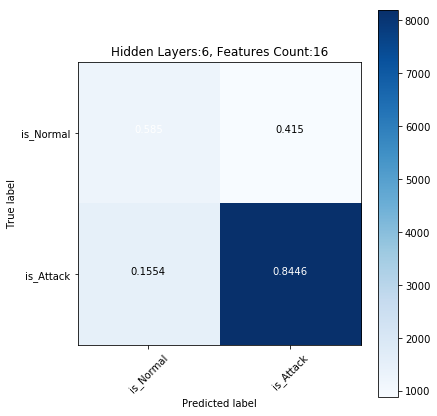

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)

In [17]:
plot(actual_value = Train.actual_value_, pred_value = Train.pred_value_)

AttributeError: type object 'Train' has no attribute 'actual_value_'